# Forecasting with an RNN

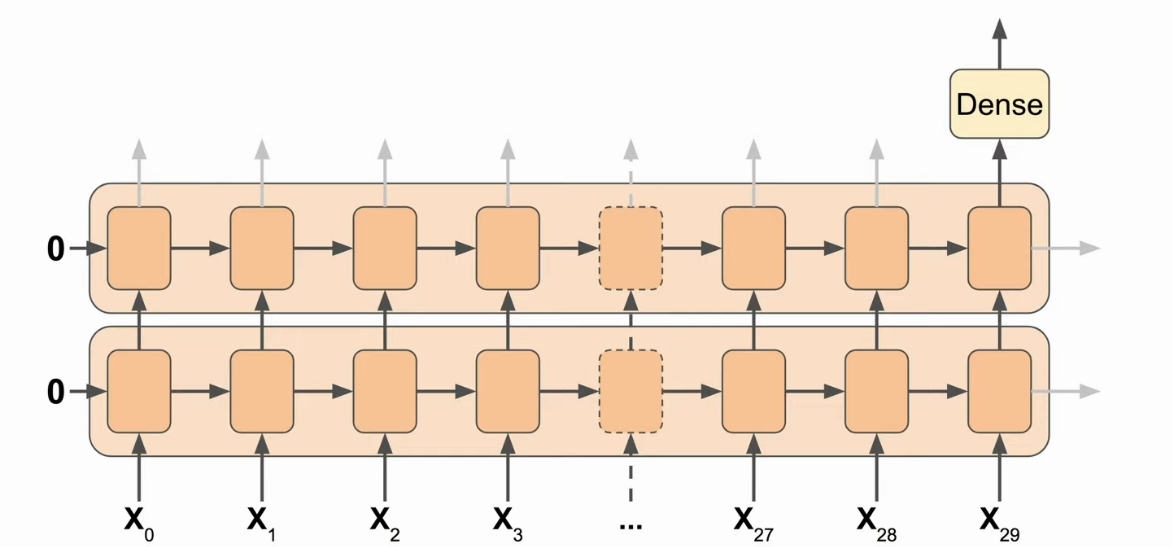

* Instable gradients, can vanish or explode

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/energydata_complete.csv")

In [3]:
ts = df["Appliances"]

In [4]:
ts.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

In [5]:
dates = pd.to_datetime(df.date)

In [6]:
series = np.asarray(ts.values)

In [7]:
time = np.arange(series.shape[0])

In [8]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

In [10]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 20000):
    dataset = tf.data.Dataset.from_tensor_slices(series) #instead of random values we are doing it with the data
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size = shuffle_buffer) #IID gd works best #buffersize must be greater or equal to the number of examples
    dataset = dataset.batch(batch_size).prefetch(1) # you probably will want bigger batchs like 32 / 64
    return dataset

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

In [12]:
split_time = int(series.shape[0] * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset